In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
data_dir = Path("./data")

cities = pd.read_csv(data_dir / "cities.csv")
providers = pd.read_csv(data_dir / "providers.csv")
stations = pd.read_csv(data_dir / "stations.csv")
ticket_data = pd.read_csv(data_dir / "ticket_data.csv")


Les csv ressemblent beaucoup a des dumps de base de données relationelles, peut-être pas en 2NF vu le format de middle_station/other comapnies.

In [3]:
# remplace l'index généré par pandas par les id existants, utile plus tard pour join les dataFrames
cities.set_index("id", inplace=True)
cities.head()

,local_name,unique_name,latitude,longitude,population
id,,,,,
5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


In [4]:
providers.set_index("id", inplace=True)
providers.head()

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
id,,,,,,,,,
9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
11,3,NaN,infobus,Infobus,False,False,False,False,bus
12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
13,5,NaN,flixbus,Flixbus,True,False,False,False,bus


In [5]:
providers.transport_type = providers.transport_type.astype("category")

In [6]:
stations.set_index("id", inplace=True)
stations.head()

,unique_name,latitude,longitude
id,,,
1,Aalen (Stuttgarter Straße),48.835296,10.092956
2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
3,Aéroport CDG,49.009900,2.559310
4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
5,Aéroport de Dresden,51.123604,13.764737


In [7]:
ticket_data.set_index("id", inplace=True)
ticket_data.head()

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
id,,,,,,,,,,,
6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


In [8]:
ticket_data.dtypes

company              int64
o_station          float64
d_station          float64
departure_ts        object
arrival_ts          object
price_in_cents       int64
search_ts           object
middle_stations     object
other_companies     object
o_city               int64
d_city               int64
dtype: object

Change le type de certaines colonnes pour faciliter la manipulation  
station -> int (pas nécessaire mais parait plus logique pour des id)  
*_ts -> timestamps   
middle_stations & other_companies -> list (pas idéal comme format car pandas ne peut pas optimiser les opérations sur des listes python)

str_to_list sert a convertir les colonnes middle_stations et other_companies en list  


In [9]:
def str_to_list(value):
    """ Convert str with format "{n1,n2,n3}" to list [n1, n2, n3], [] if "NaN" """
    if pd.isna(value):
        return []
    
    assert value[0] == "{" and value[-1] == "}"
    ids = value[1:-1].split(",")
    return list(map(int, ids))

assert str_to_list("{1105,1105}") == [1105, 1105]
assert str_to_list("{798,798,6794,6246}") == [798,798,6794,6246]
assert str_to_list(float("nan")) == []

In [10]:
ticket_data["o_station"] = ticket_data["o_station"].astype(pd.Int64Dtype())
ticket_data["d_station"] = ticket_data["d_station"].astype(pd.Int64Dtype())

ticket_data["departure_ts"] = pd.to_datetime(ticket_data["departure_ts"])
ticket_data["arrival_ts"] = pd.to_datetime(ticket_data["arrival_ts"])
ticket_data["search_ts"] = pd.to_datetime(ticket_data["search_ts"])

ticket_data["middle_stations"] = ticket_data["middle_stations"].apply(str_to_list)
ticket_data["other_companies"] = ticket_data["other_companies"].apply(str_to_list)

In [11]:
all(ticket_data.middle_stations.map(len) == ticket_data.other_companies.map(len) * 2)

True

middle station a toujours un nombre paire de stations (le sous trajet 1 correspond se fait de o_station à middle station 1, le sous trajet 2 de middle station 2 à middle station 3, ..., middle station N à d_station)    
other_companies n correspond a la societe sur la partie n + 1 du trajet.  
Company pour le sous trajet 1 et le trajet complet dans le cas ou il n'y a pas de changement.

# Stats des prix des tickets en euros

In [12]:
# cents to euros
price_in_euro = ticket_data.price_in_cents / 100
price_in_euro.describe()

count    74168.000000
mean        43.827111
std         37.393254
min          3.000000
25%         19.000000
50%         33.500000
75%         52.500000
max        385.500000
Name: price_in_cents, dtype: float64

Text(0.5, 1.0, 'Histogramme des prix de ticket, en euros')

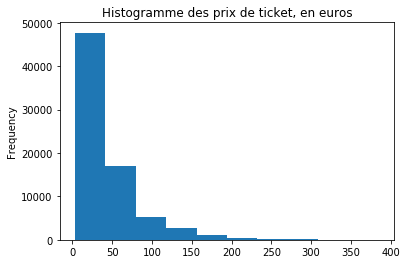

In [13]:
price_in_euro.plot.hist()
plt.title("Histogramme des prix de ticket, en euros")

# Statistiques de durée des trajets

moyenne 7h, grande variance (std 9h54), médiane 4h50, 75% des trajets durent plus de 3h.

In [14]:
duration = ticket_data.arrival_ts - ticket_data.departure_ts
ticket_data["duration"] = duration
duration.describe()

count                     74168
mean     0 days 07:04:37.247600
std      0 days 09:54:58.881351
min             0 days 00:20:00
25%             0 days 03:00:00
50%             0 days 04:50:00
75%             0 days 08:00:00
max            20 days 12:51:00
dtype: object

# Combien de temps avant le départ les ticket ont été recherché

moyenne 7 jours, mediane 4 jours, 25% moins de 2 jours avant  
Quelques anomalies de tickets recherchés après la fin du trajet (258 cas)

In [15]:
(ticket_data.departure_ts - ticket_data.search_ts).describe()

count                        74168
mean        7 days 05:31:22.521769
std        10 days 13:57:13.419074
min      -24 days +00:19:00.657000
25%         1 days 23:01:39.281250
50%         4 days 03:00:07.441000
75%         8 days 11:01:03.883250
max       176 days 09:13:22.421000
dtype: object

In [16]:
(ticket_data.search_ts > ticket_data.arrival_ts).sum()

258

# Stats de distance des trajets

Distance entre deux points

https://en.wikipedia.org/wiki/Haversine_formula

https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [17]:
import numpy as np

def distance(*args):
    """ Distance in km between two pairs of lat, long coordinates
    
    args: Dataframe containing colmuns lat_A, lon_A, lat_B, lon_B 
          or lat_A, lon_A, lat_B, lon_B
    """
    if len(args) == 1:
        df = args[0]
        s_lat, s_lng, e_lat, e_lng = df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2], df.iloc[:, 3]
    else:
        s_lat, s_lng, e_lat, e_lng = args

    # approximate radius of earth in km
    R = 6367.0
    deg2rad = np.pi/180.0
    s_lat = deg2rad * s_lat
    s_lng = deg2rad * s_lng
    e_lat = deg2rad * e_lat
    e_lng = deg2rad * e_lng

    d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

    return 2 * R * np.arcsin(np.sqrt(d))
# test de la fonction
cities[cities.local_name.str.contains("Paris")]
print(cities.loc[[148, 628]])
# Paris - Brest: ~505km
distance(48.409291, -4.474692, 48.847702, 2.352311)

                       local_name unique_name   latitude  longitude  \
id                                                                    
148       Brest, Bretagne, France       brest  48.409291  -4.474692   
628  Paris, Île-de-France, France       paris  48.847702   2.352311   

     population  
id               
148    139384.0  
628         NaN  


503.611053691147

Pour calculer les distances entre villes d'origine et d'arrivée du ticket il faut récupérer les coordonnées depuis la table cities  
merge est une fonction similaire a join en SQL

In [18]:
ticket_distance = ticket_data[["o_station", "d_station", "middle_stations", "o_city", "d_city"]].merge(
        cities[["latitude", "longitude"]], left_on="o_city", right_index=True, suffixes=("_x", "_origin")
    ).merge(
        cities[["latitude", "longitude"]], left_on="d_city", right_index=True, suffixes=("_origin", "_destination")
    )
ticket_distance.head()

,o_station,d_station,middle_stations,o_city,d_city,latitude_origin,longitude_origin,latitude_destination,longitude_destination
id,,,,,,,,,
6795025,<NA>,<NA>,[],611,542,47.907018,1.90627,43.604452,3.918318
6795026,63,1044,"[149, 418]",611,542,47.907018,1.90627,43.604452,3.918318
6795027,5905,6495,"[798, 798, 6794, 6246]",611,542,47.907018,1.90627,43.604452,3.918318
6795028,5905,6495,"[798, 798, 6794, 6246]",611,542,47.907018,1.90627,43.604452,3.918318
6795029,5905,6495,"[5983, 5983]",611,542,47.907018,1.90627,43.604452,3.918318


In [19]:
# distance entre ville d'origine et d'arrivée
city_distances = distance(ticket_distance[["latitude_origin", "longitude_origin", "latitude_destination", "longitude_destination"]])
ticket_data["distance"] = city_distances
city_distances.describe()

count    74168.000000
mean       362.810249
std        194.808228
min         18.901367
25%        205.713353
50%        338.107722
75%        480.112194
max       1868.997843
dtype: float64

Text(0.5, 1.0, "Histogramme de la distance entre villes d'origine et de destination, en km")

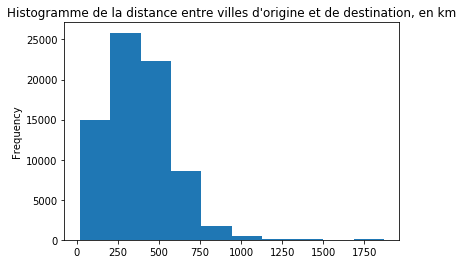

In [20]:
city_distances.plot.hist()
plt.title("Histogramme de la distance entre villes d'origine et de destination, en km")

# Prix selon le type de transport et la distance

Partant du principe que peut de ticket ont différents moyen de transport j'utilise uniquement celui du premier provider, je vérifie plus loin la validité de l'hypothèse

In [21]:
# add first_transport column corresponding to 'company' transport type
ticket_data["first_transport"] = ticket_data[["company"]].join(providers, on="company")["transport_type"]
ticket_data.head()

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,distance,first_transport
id,,,,,,,,,,,,,,
6795025,8385,<NA>,<NA>,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,[],[],611,542,0 days 06:10:00,502.881237,carpooling
6795026,9,63,1044,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"[149, 418]",[13],611,542,0 days 17:50:00,502.881237,bus
6795027,8377,5905,6495,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"[798, 798, 6794, 6246]","[8377, 8376]",611,542,1 days 07:57:00,502.881237,train
6795028,8377,5905,6495,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"[798, 798, 6794, 6246]","[8377, 8376]",611,542,0 days 21:35:00,502.881237,train
6795029,8381,5905,6495,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"[5983, 5983]",[8380],611,542,0 days 21:46:00,502.881237,train


In [22]:
distance_bins = [0, 200, 800, 2000] # pas de distance de plus de 2000km a vol d'oiseau
ticket_data["distance_bins"] = pd.cut(city_distances, distance_bins)
ticket_data.distance_bins.value_counts() / len(ticket_data)

(200, 800]     0.793590
(0, 200]       0.185282
(800, 2000]    0.021128
Name: distance_bins, dtype: float64

80% des tickets sont pour distance entre 200 et 800km

Text(0.5, 1.0, 'Prix du ticket en centimes selon le type de transport et la distance')

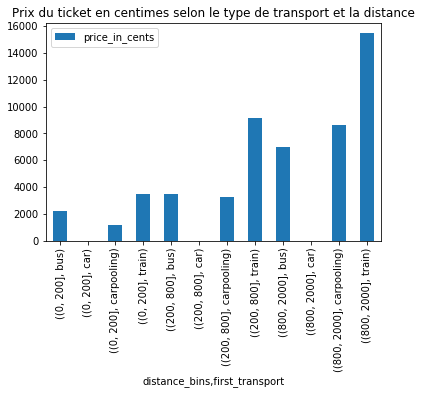

In [23]:
ticket_data[["distance_bins", "price_in_cents", "first_transport"]].groupby(["distance_bins", "first_transport"]).mean().plot.bar()
plt.title("Prix du ticket en centimes selon le type de transport et la distance")

Text(0.5, 1.0, 'Prix (en centimes) par distance (km) des tickets')

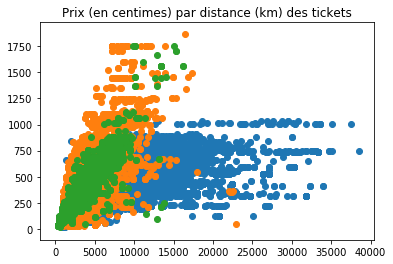

In [24]:
# Pourrait faire des regressions linéaire pour avoir un intervalle de confiance de prix par distance et type de transport
# Peut etre utile pour indiquer si un ticket et beaucoup plus ou moins chere que d'autres tickets similaires
train_idx = ticket_data["first_transport"] == "train" 
plt.scatter(ticket_data.price_in_cents[train_idx], ticket_data.distance[train_idx], label="train")
bus_idx = ticket_data["first_transport"] == "bus" 
plt.scatter(ticket_data.price_in_cents[bus_idx], ticket_data.distance[bus_idx], label="bus")
carpool_idx = ticket_data["first_transport"] == "carpooling" 
plt.scatter(ticket_data.price_in_cents[carpool_idx], ticket_data.distance[carpool_idx], label="carpool")
plt.title("Prix (en centimes) par distance (km) des tickets")

## Idem mais pour la durée du trajet

Le bus est de loin le moyen de transport de plus lent, la voiture est le plus rapide en dessous de 800km, le train et plus rapide pour les trajets de plus de 800km.

C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


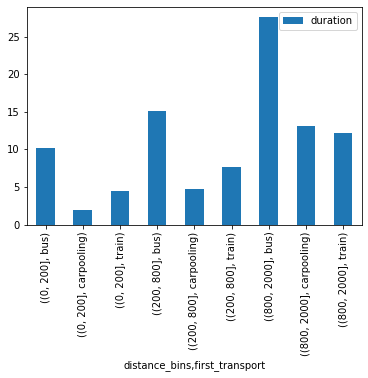

In [40]:
ticket_duration_data = ticket_data[["distance_bins", "duration", "first_transport"]]
ticket_duration_data["duration"] = ticket_duration_data.duration.dt.total_seconds() / 3600 # en heures
ticket_duration_data.first_transport.cat.remove_unused_categories(inplace=True) # remove cars
ticket_duration_data.groupby(["distance_bins", "first_transport"]).mean().plot.bar()

# La distance entre les villes est elle représentative de la distance parcourue en prenant les changements en compte?  
Le but est d'obtenir la somme des distances entre stations.

In [26]:
print("Pas de changement", (ticket_data.middle_stations.map(len) == 0).sum() / len(ticket_data))
print("1 changement", (ticket_data.middle_stations.map(len) == 2).sum() / len(ticket_data))
print("2 changements", (ticket_data.middle_stations.map(len) == 4).sum() / len(ticket_data))
print("3 changements", (ticket_data.middle_stations.map(len) == 6).sum() / len(ticket_data))

Pas de changement 0.5587450113256391
1 changement 0.4208283896019847
2 changements 0.016880595405026427
3 changements 0.0035460036673498002


In [27]:
# Premier essai pour calculer des distances intermédiaires entre stations
# trop lent du au nombre de ligne important, il faut trouver un moyen de 'vectoriser'
def get_coord(idx, df):
    return tuple(df.loc[idx][["latitude", "longitude"]])
def total_distance(row):
    """ Somme des distance de trajets entre stations """
    trips = []
    if row.o_station == np.nan:
        trips.append(get_coord(row.o_station, stations))
    else:
        trips.append(get_coord(row.o_city, cities))
    for station_id in row["middle_stations"][::2]:
        trips.append(get_coord(station_id, stations))
    if row.d_station == np.nan:
        trips.append(get_coord(row.d_station, stations))
    else:
        trips.append(get_coord(row.d_city, cities))
    acc_distance = 0
    for pointa, pointb in zip(trips[:-1], trips[1:]):
        acc_distance += distance(*pointa, *pointb)
    return acc_distance

# ticket_data.apply(total_distance, axis=1)

In [28]:
# Vérifie si tous les tickets qui ont des stations intermédiaires ont o_station et d_station de défini
# Si oui on peut se passer de city_* pour le calcul de la distance
# astype sur des list donne False pour les listes vides
print("o and d station définis en même temps:", all(ticket_data.o_station.isna() == ticket_data.d_station.isna()))
all(~ticket_data.o_station.isna() == ticket_data.middle_stations.astype(bool))

o and d station définis en même temps: True


True

In [29]:
# il faut recalculer la distance uniquement pour les trajets avec des changements
# le but est de créer une table (id_ticket, distance) que l'ont peu aggréger pour calculer la distance totale pour un ticket

# trips_data contient la liste de tous les trajets sous forme
# id du ticket, id station origin, id station destination, provider id
# chaque sous trajet est en element différent dans la liste, avec le même id mais origin et destination différents
trips_data = []
tickets_with_middlestations = ticket_data.middle_stations.astype(bool)

for row in ticket_data[tickets_with_middlestations].itertuples():
    trips = []
    trips.append(row.o_station)
    # j'ajoute toutes les stations à la suite pour prendre en compte la distance des changements
    trips.extend(row.middle_stations)
    trips.append(row.d_station)
    companies = [row.company] + row.other_companies
    # une distance sur deux n'a pas de company associée
    companies = [comp_or_none for company in companies for comp_or_none in (company, None)]
    trips_data.extend(zip([row.Index]*len(trips), trips[:-1], trips[1:], companies))

trips_df = pd.DataFrame(trips_data, columns=["ticket_id", "origin", "dest", "company"])
# Join pour obtenir les données des stations
trips_df = trips_df.join(stations, on="origin").join(stations, on="dest", rsuffix="_dest")
# calcul des distances pour chaque trajet
trips_df["distance"] = distance(trips_df[["latitude", "longitude", "latitude_dest", "longitude_dest"]])
trips_df.head()

,ticket_id,origin,dest,company,unique_name,latitude,longitude,unique_name_dest,latitude_dest,longitude_dest,distance
0,6795026,63,149,9.0,Avenue Georges Pompidou,47.896911,1.854277,Chambre de Commerce,47.063820,2.368150,100.299014
1,6795026,149,418,NaN,Chambre de Commerce,47.063820,2.368150,Gare routière de Bourges,47.082474,2.386704,2.503775
2,6795026,418,1044,13.0,Gare routière de Bourges,47.082474,2.386704,Station Les Sabines,43.583932,3.860233,405.438051
3,6795027,5905,798,8377.0,Les Aubrais,47.926740,1.906740,Montluçon (Central bus station),46.337443,2.597606,184.169659
4,6795027,798,798,NaN,Montluçon (Central bus station),46.337443,2.597606,Montluçon (Central bus station),46.337443,2.597606,0.000000


In [30]:
# somme de tous les trajets appartenant au même ticket
ticket_data["trip_length"] = trips_df[["ticket_id", "distance"]].groupby("ticket_id").sum()

Text(0.5, 1.0, 'Somme des distances entre stations pour les trajets avec changement, en km')

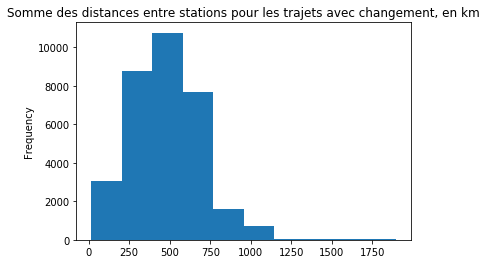

In [31]:
ticket_data.trip_length.plot.hist()
plt.title("Somme des distances entre stations pour les trajets avec changement, en km")

En moyenne la somme des distances entre les stations du trajet et la distance a vol d'oiseau entre villes sont très proches
médiane 2% plus long

il y a quelques incohérences au niveau des distances, la distance de ville à ville ne devrait pas être beaucoup plus importante que le somme des sous parties du trajet (plus court de 70% pour le min)

In [32]:
(ticket_data["trip_length"] / ticket_data["distance"]).describe()

count    32727.000000
mean         1.161570
std          0.506651
min          0.275785
25%          1.004533
50%          1.026473
75%          1.116410
max         40.448865
dtype: float64

## Dans quel cas la distance parcourue est plus de 2 fois supérieur à la distance à vol d'oiseau entre les villes?

In [33]:
ticket_data[(ticket_data["distance"] / ticket_data["trip_length"]) > 2.0]

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration,distance,first_transport,distance_bins,trip_length
id,,,,,,,,,,,,,,,,
6842622,8377,10876,4172,2017-10-13 06:42:00+00:00,2017-10-13 17:48:00+00:00,1940,2017-10-12 21:53:30.448000+00:00,"[4557, 4557]",[8380],628,122,11:06:00,838.108161,train,"(800, 2000]",231.137396
6842623,8380,10876,4172,2017-10-13 16:36:00+00:00,2017-10-14 07:13:00+00:00,5130,2017-10-12 21:53:30.449000+00:00,"[8250, 8250, 5488, 5488]","[8380, 8380]",628,122,14:37:00,838.108161,train,"(800, 2000]",242.129152
6842624,8377,10876,4172,2017-10-13 15:12:00+00:00,2017-10-13 18:45:00+00:00,4440,2017-10-12 21:53:30.449000+00:00,"[4557, 4557]",[8380],628,122,03:33:00,838.108161,train,"(800, 2000]",231.137396
6842625,8377,10876,4172,2017-10-13 14:12:00+00:00,2017-10-13 17:48:00+00:00,3940,2017-10-12 21:53:30.448000+00:00,"[4557, 4557]",[8380],628,122,03:36:00,838.108161,train,"(800, 2000]",231.137396
6842626,8380,10876,4172,2017-10-13 19:36:00+00:00,2017-10-14 07:13:00+00:00,4800,2017-10-12 21:53:30.449000+00:00,"[974, 974]",[8380],628,122,11:37:00,838.108161,train,"(800, 2000]",241.115752
6842627,8377,10876,4172,2017-10-13 20:42:00+00:00,2017-10-14 06:33:00+00:00,3940,2017-10-12 21:53:30.449000+00:00,"[4557, 4557]",[8380],628,122,09:51:00,838.108161,train,"(800, 2000]",231.137396


In [34]:
# d_station et o_statin, et o_city et d_city identique dans tous les cas
trips_df[trips_df.ticket_id == 6842622]

,ticket_id,origin,dest,company,unique_name,latitude,longitude,unique_name_dest,latitude_dest,longitude_dest,distance
60960,6842622,10876,4557,8377.0,Gare de l'Est,48.878632,2.361908,Chaumont,48.10996,5.13417,221.287214
60961,6842622,4557,4557,NaN,Chaumont,48.109960,5.134170,Chaumont,48.10996,5.13417,0.000000
60962,6842622,4557,4172,8380.0,Chaumont,48.109960,5.134170,Bologne,48.19860,5.13460,9.850182


In [35]:
# stationde départ et ville de départ
stations.loc[4172].unique_name, cities.loc[122].local_name

('Bologne', 'Bologna, Emilia-Romagna, Italia')

Le problème est identique pour tous ces tickets, une erreur entre Bologne (Haute marte) et Bologne Italie 

# Quels sont les moyens de transport les plus utilisés en prenant en compte les sous trajets


In [36]:
all_trips = trips_df.set_index("ticket_id") # avoid duplicates when adding direct trips
all_trips = all_trips.append(ticket_data[~tickets_with_middlestations][["company", "distance"]])
all_trips = all_trips.join(providers, on="company")[["distance", "transport_type"]]
all_trips.head()

,distance,transport_type
6795026,100.299014,bus
6795026,2.503775,NaN
6795026,405.438051,bus
6795027,184.169659,train
6795027,0.000000,NaN


283 tickets ont différents moyen de transport, sur 74k, confirme l'hypothèse que l'ont a fait précédement

In [37]:
(all_trips.groupby(all_trips.index).transport_type.nunique() > 1).sum()

283

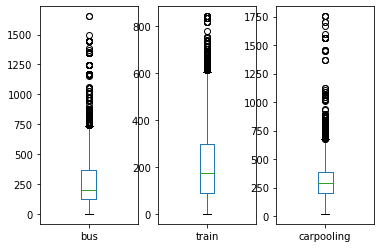

In [38]:
plt.subplot(131)
all_trips[all_trips.transport_type == "bus"].distance.plot.box(label="bus")
plt.subplot(132)
all_trips[all_trips.transport_type == "train"].distance.plot.box(label="train")
plt.subplot(133)
all_trips[all_trips.transport_type == "carpooling"].distance.plot.box(label="carpooling")

Covoiturage et bus sont utilisés pour pour des distances similaires (autour de 250km), le train est en général utilisé pour des distances plus courtes (200km).

# Vitesse moyenne du trajet selon le prix et moyen de transport

Pas de corrélation

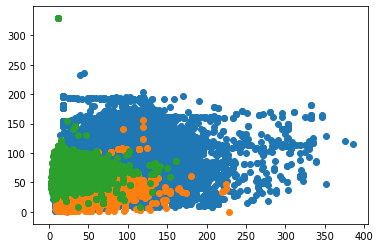

In [39]:
# vitesse moyenne du trajet en km/h
mean_speed = ticket_data.distance / (ticket_data.arrival_ts - ticket_data.departure_ts).dt.total_seconds() * 3600
plt.scatter(ticket_data.price_in_cents[train_idx] / 100, mean_speed[train_idx]) # bleu
plt.scatter(ticket_data.price_in_cents[bus_idx] / 100, mean_speed[bus_idx]) # orange
plt.scatter(ticket_data.price_in_cents[carpool_idx] / 100, mean_speed[carpool_idx]) # vert


Autres idées de recherche:
- stations les plus utilisées
- origine et destination les plus corrélées, trajets les plus poplaires
- trajets les plus rapide/plus long par rapport à la distance